In [1]:
import torch
from torch import nn

from uniphm.data import Dataset
from uniphm.data.labeler.BearingFaultLabeler import BearingFaultLabeler
from uniphm.data.loader.XJTULoader import XJTULoader, Fault
from uniphm.data.process.EntityPipeline import EntityPipeline
from uniphm.data.process.array.RMSProcessor import RMSProcessor
from uniphm.engine.Evaluator import Evaluator
from uniphm.engine.metric.Accuracy import Accuracy
from uniphm.engine.metric.WeightedF1Score import WeightedF1Score
from uniphm.data.process.entity.ThreeSigmaFPTCalculator import ThreeSigmaFPTCalculator
from uniphm.engine.tester.BaseTester import BaseTester
from uniphm.engine.trainer.BaseTrainer import BaseTrainer
from uniphm.engine.callback.CheckGradientsCallback import CheckGradientsCallback
from uniphm.engine.callback.EarlyStoppingCallback import EarlyStoppingCallback
from uniphm.engine.callback.TensorBoardCallback import TensorBoardCallback
from uniphm.model.basic.CNN import CNN
from uniphm.util.Cache import Cache
from uniphm.util.Plotter import Plotter

In [2]:
cache_dataset = True
# cache_dataset = False
# cache_model = True
cache_model = False

fault_types = [Fault.NC, Fault.OF, Fault.IF, Fault.CF]

# 获取数据集

In [3]:
dataset = Cache.load('diagnosis_dataset', is_able=cache_dataset)
if dataset is None:
    data_loader = XJTULoader('D:\\data\\dataset\\XJTU-SY_Bearing_Datasets')
    labeler = BearingFaultLabeler(2048, fault_types, is_multi_hot=False, is_from_fpt=False)
    pipeline = EntityPipeline()
    pipeline.register(
        processor=RMSProcessor(data_loader['continuum']),
        input_key='Horizontal Vibration',
        output_key='RMS'
    )
    pipeline.register(
        processor=ThreeSigmaFPTCalculator(),
        input_key='RMS',
    )

    # 通过其他轴承增加训练数据
    dataset = Dataset()
    for bearing_name in ['Bearing1_1', 'Bearing1_2', "Bearing1_3",
                         'Bearing2_3', 'Bearing2_2', 'Bearing2_4', 'Bearing2_5',
                         'Bearing3_3']:
        bearing = data_loader(bearing_name, include='Horizontal Vibration')
        pipeline.execute(bearing)
        dataset.append_entity(labeler(bearing, 'Horizontal Vibration'))
    Cache.save(dataset, 'diagnosis_dataset')

[DEBUG   17:25:44]  [Cache]  -> Loading cache file: .\cache\diagnosis_dataset.pkl
[DEBUG   17:25:44]  [Cache]  ✓ Successfully loaded: .\cache\diagnosis_dataset.pkl


# 划分数据集：训练集（70%）、验证集（15%）、测试集（15%）
- 训练集：用于模型参数学习
- 验证集：用于模型调参、早停（early stopping）、选择最佳模型
- 测试集：只用于最终性能评估，不参与任何训练和调参过程

In [4]:
train_set, test_set = dataset.split_by_ratio(0.7)
val_set, test_set = test_set.split_by_ratio(0.5)

[INFO    17:25:44]  [Dataset]  Splitting data by ratio 0.7 using random seed: 189104666664043153727204700797448531093
[INFO    17:25:46]  [Dataset]  Splitting data by ratio 0.5 using random seed: 235068290572820748982181007615771808556


# 配置测试算法

In [5]:
tester = BaseTester()

# 配置训练算法

In [6]:
train_config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dtype': torch.float32,
    'epochs': 10,
    'batch_size': 128,
    'lr': 0.001,
    'weight_decay': 0.0,
    'criterion': nn.CrossEntropyLoss(),
    'callbacks': [
        EarlyStoppingCallback(patience=20,
                              val_set=test_set,
                              metric=Accuracy(),
                              tester=tester),
        TensorBoardCallback(),
        CheckGradientsCallback()
    ]
}
trainer = BaseTrainer(config=train_config)

# 定义模型并训练

[INFO    17:25:47]  
[Trainer]  Start training by BaseTrainer:
	training set: Bearing1_1; Bearing1_2; Bearing1_3;…
	device: cuda
	dtype: torch.float32
	epochs: 10
	batch_size: 128
	lr: 0.001
	weight_decay: 0.0
	criterion: CrossEntropyLoss()
	callbacks: [EarlyStoppingCallback, TensorBoardCallback, CheckGradientsCallback]
	optimizer: Adam
[DEBUG   17:25:47]  [EarlyStopping]  On the validation set Bearing1_1; Bearing1_2; Bearing1_3; Bearing2_3; Bearing2_2; Bearing2_4; Bearing2_5; Bearing3_3, the Accuracy is 0.1299
[INFO    17:25:49]  [BaseTrainer]  Epoch [1/10], CrossEntropyLoss:0.4433
[DEBUG   17:25:49]  [EarlyStopping]  On the validation set Bearing1_1; Bearing1_2; Bearing1_3; Bearing2_3; Bearing2_2; Bearing2_4; Bearing2_5; Bearing3_3, the Accuracy is 0.9363
[WARNING 17:25:49]  [CheckGradients] se1.excitation.0.weight gradient is very small: 0.00e+00
[WARNING 17:25:49]  [CheckGradients] se1.excitation.0.bias gradient is very small: 0.00e+00
[WARNING 17:25:49]  [CheckGradients] se1.excit

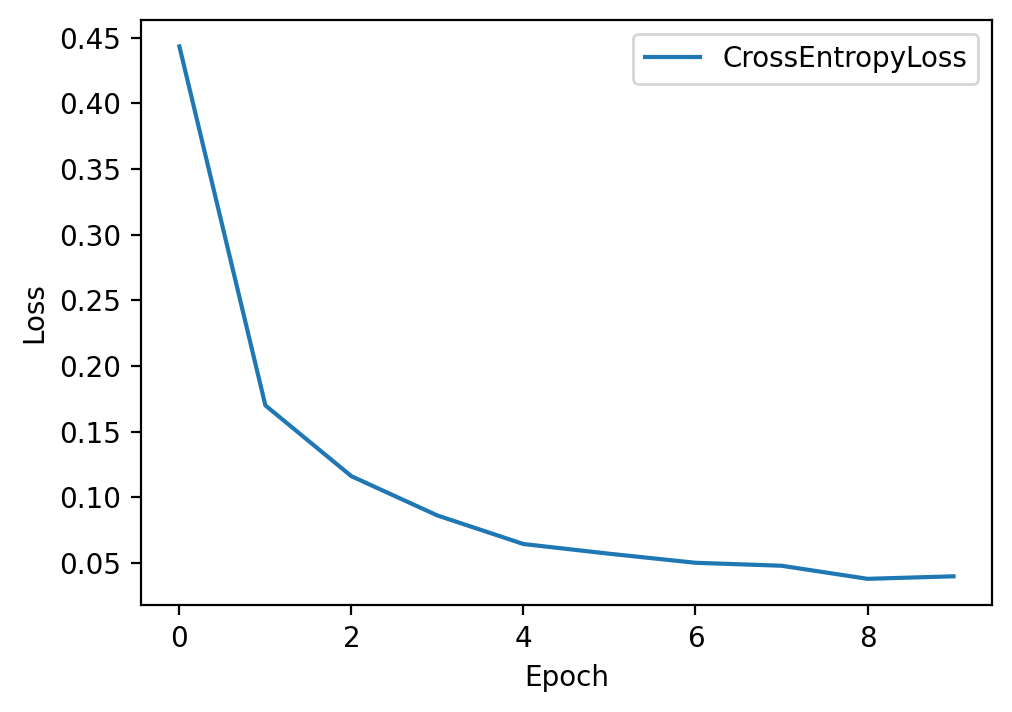

[DEBUG   17:26:06]  [Cache]  Generating cache file: .\cache\diagnosis_model.pkl
[DEBUG   17:26:06]  [Cache]  Generated cache file: .\cache\diagnosis_model.pkl


In [7]:
model = Cache.load('diagnosis_model', cache_model)
if model is None:
    model = CNN(2048, len(fault_types))
    # 配置训练算法
    # 开始训练
    losses = trainer.train(model=model, train_set=train_set)
    Plotter.loss(losses)
    Cache.save(model, 'diagnosis_model')

# 测试

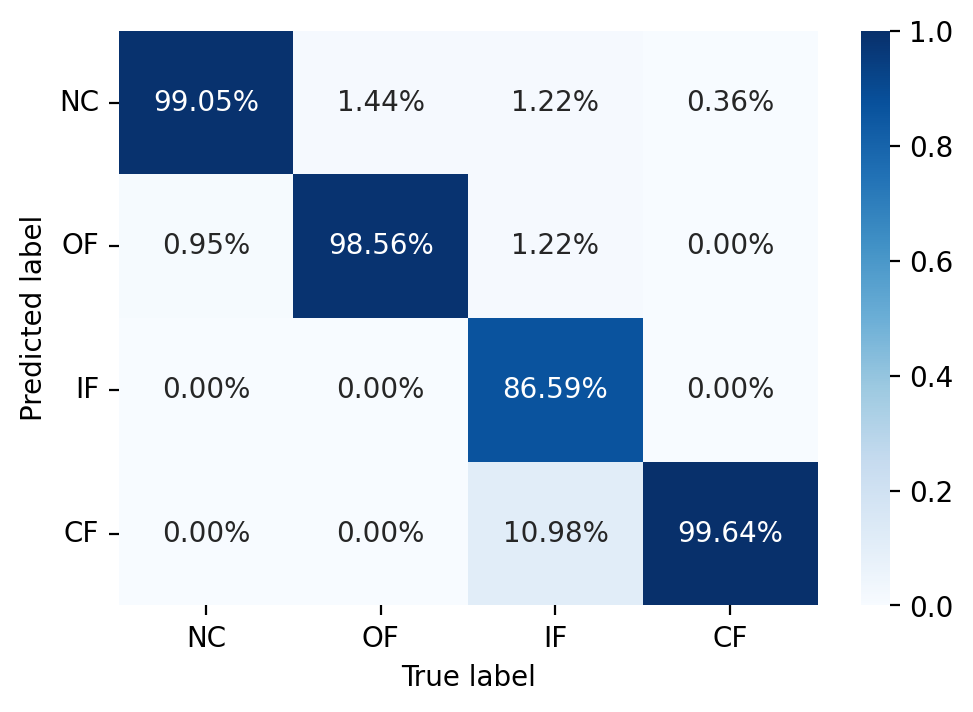

In [8]:
result = tester.test(model, test_set)
Plotter.confusion_matrix(test_set, result, types=fault_types)

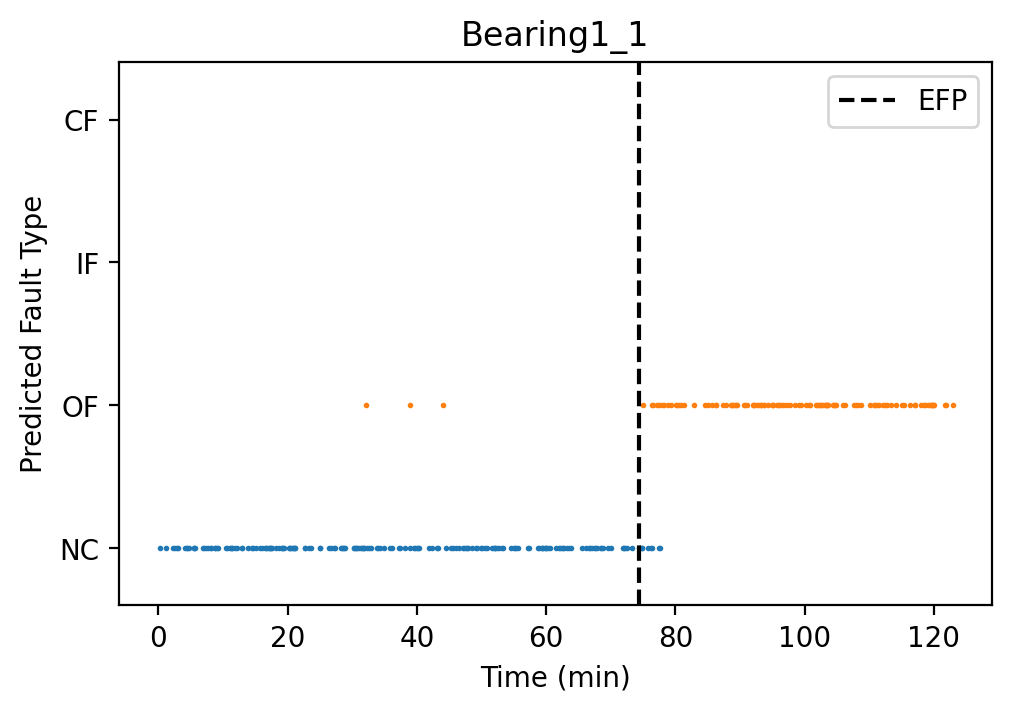

In [9]:
Plotter.fault_evolution(test_set.get('Bearing1_1'), result.get('Bearing1_1'), types=fault_types)

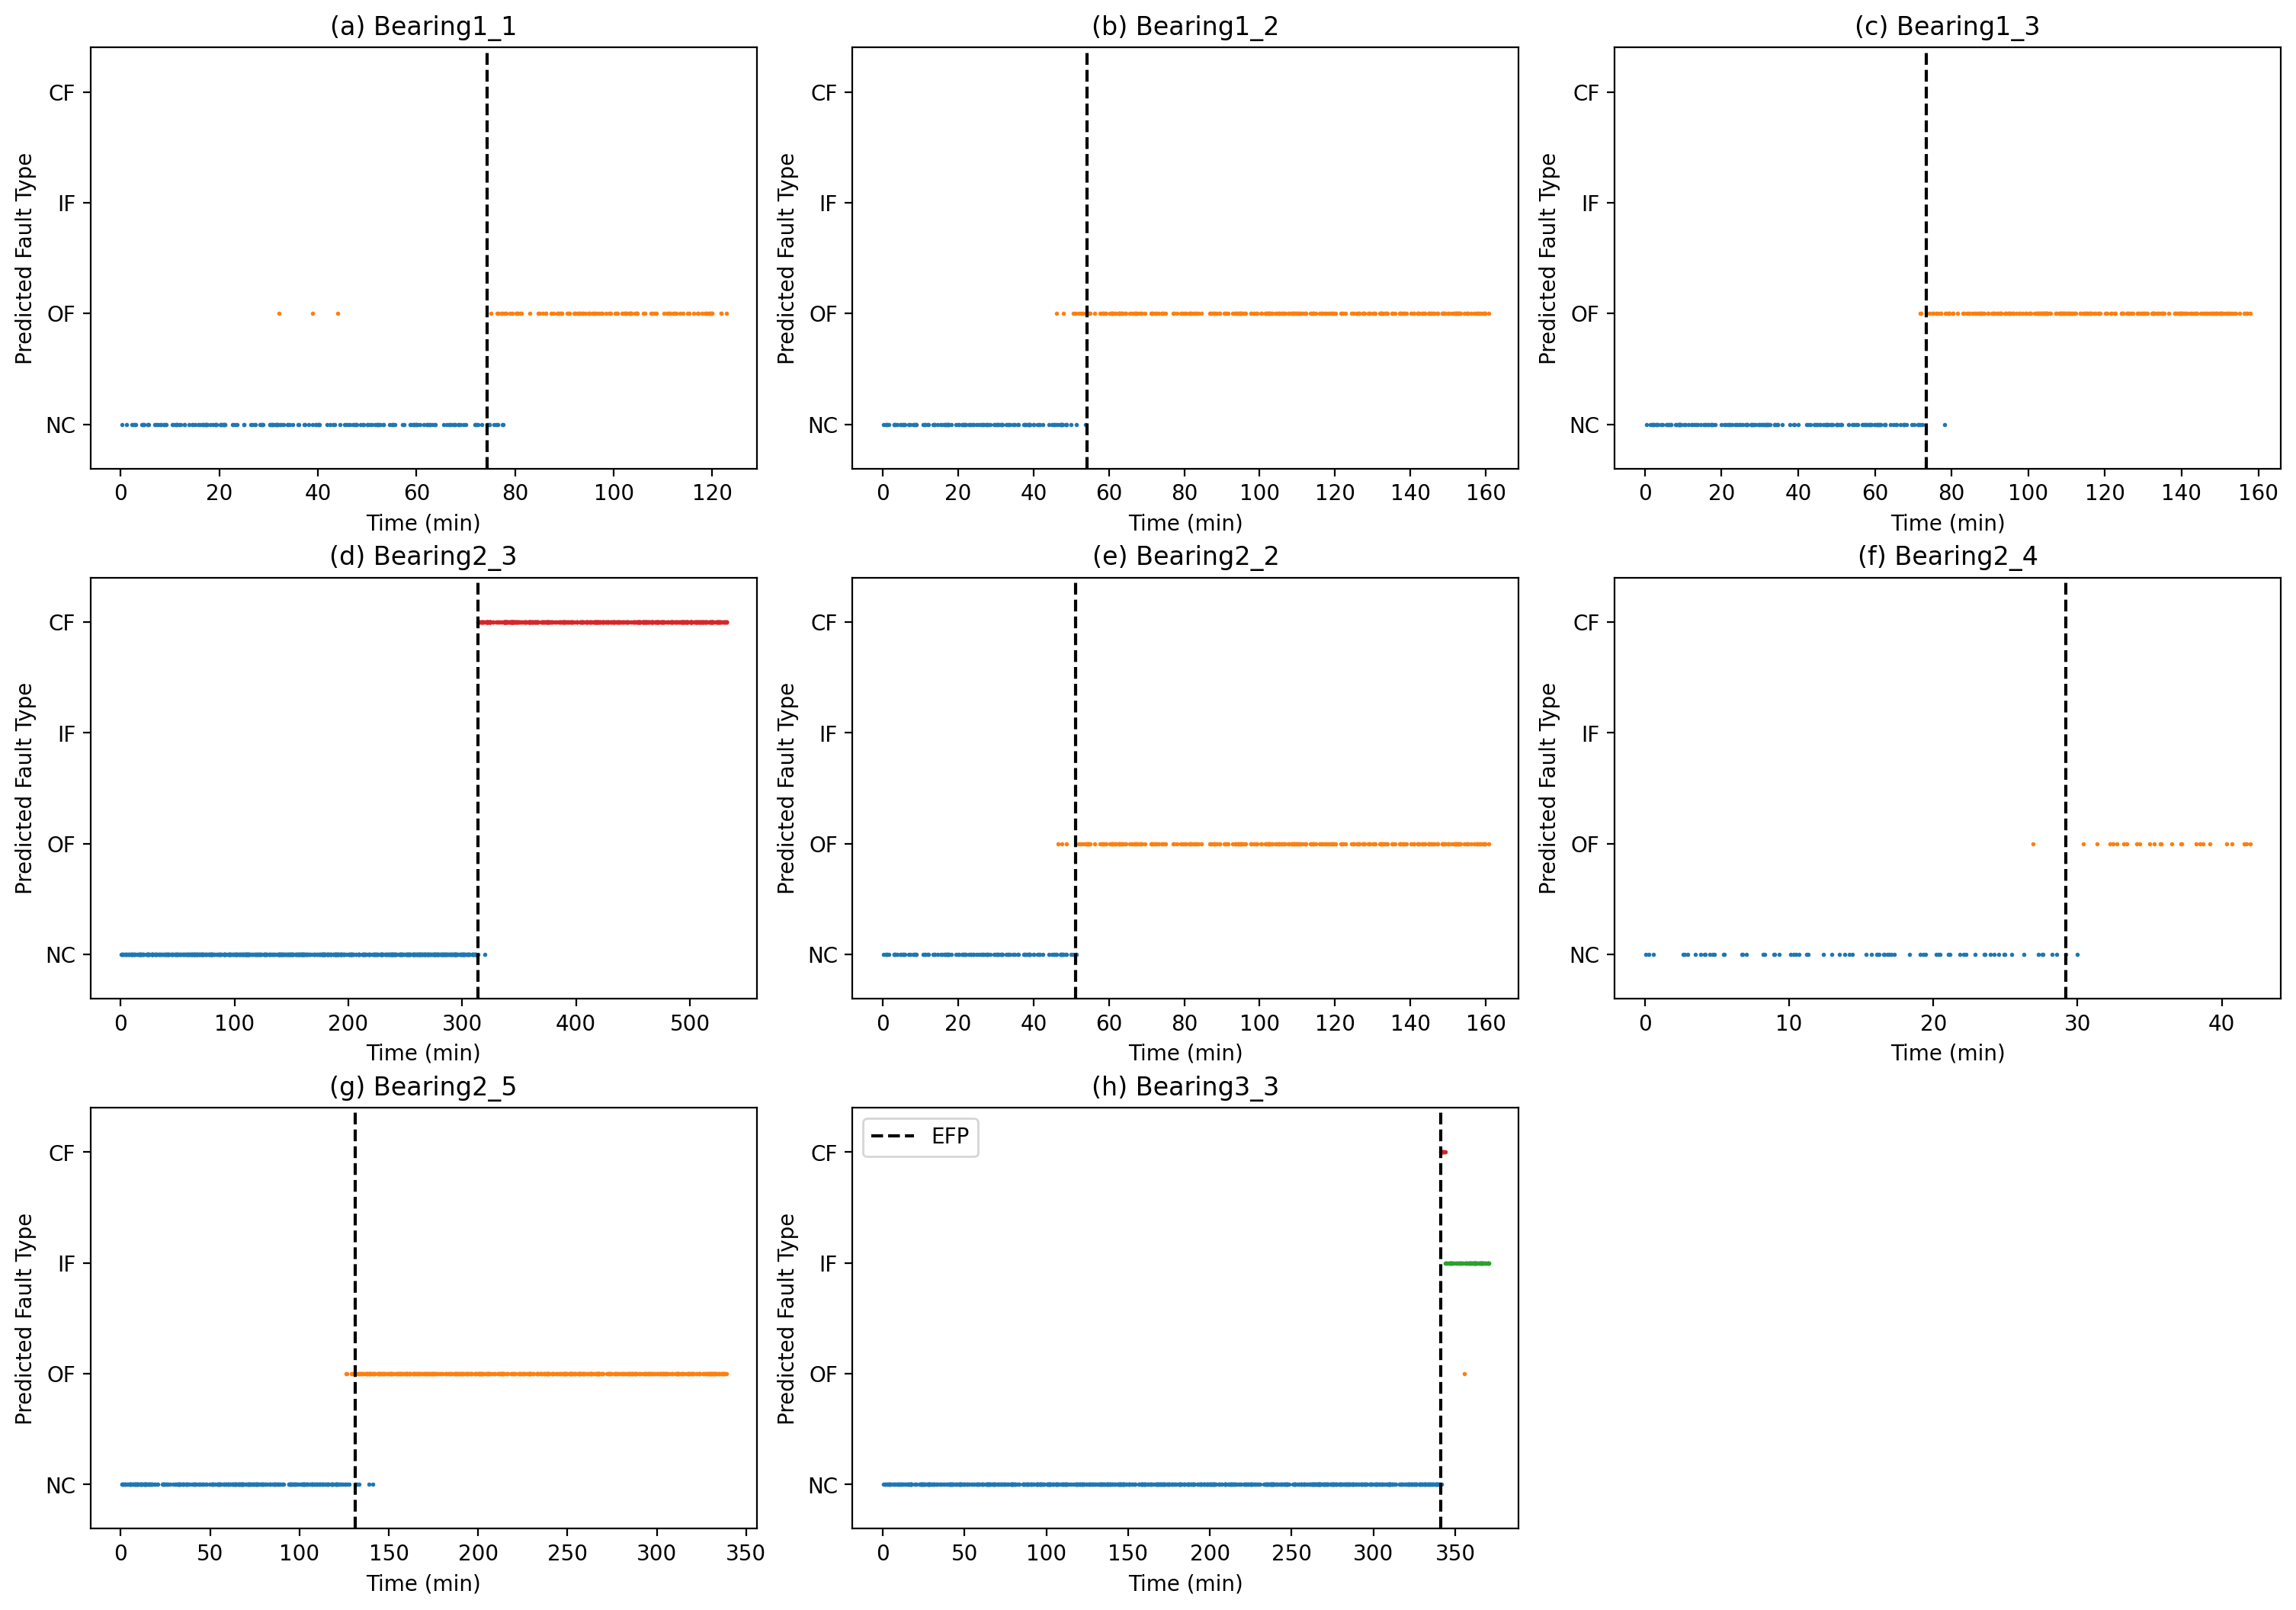

In [10]:
Plotter.fault_evolution(test_set, result, types=fault_types)

# 预测结果评价

In [11]:
evaluator = Evaluator()
evaluator.add(Accuracy(), WeightedF1Score())
evaluator(test_set, result)

[INFO    17:26:07]  
[Evaluator]  Performance Evaluation:
             Accuracy WeightedF1Score
Bearing1_1     0.9595          0.9592
Bearing1_2     0.9793          0.9791
Bearing1_3     0.9921          0.9921
Bearing2_3     0.9984          0.9984
Bearing2_2     0.9871          0.9871
Bearing2_4     0.9703          0.9701
Bearing2_5     0.9840          0.9840
Bearing3_3     0.9877          0.9928
mean(global)   0.9874          0.9874
mean(group)    0.9874          0.9884



,Accuracy,WeightedF1Score
Bearing1_1,0.9595,0.9592
Bearing1_2,0.9793,0.9791
Bearing1_3,0.9921,0.9921
Bearing2_3,0.9984,0.9984
Bearing2_2,0.9871,0.9871
Bearing2_4,0.9703,0.9701
Bearing2_5,0.9840,0.9840
Bearing3_3,0.9877,0.9928
mean(global),0.9874,0.9874
mean(group),0.9874,0.9884
